# Intro to neural net training with autograd

In this notebook, we'll practice

* using the **autograd** Python package to compute gradients
* using gradient descent to train a basic linear regression (a NN with 0 hidden layers)
* using gradient descent to train a basic neural network for regression (NN with 1+ hidden layers)


### Requirements:

Follow the Python environment setup instructions here:
https://www.cs.tufts.edu/comp/150BDL/2018f/setup_python_env.html

All the specific Python packages you'll need are in the 'bdl_basic_env' conda environment:
https://www.cs.tufts.edu/comp/150BDL/2018f/conda_envs/bdl_basic_env.yml

In [1]:
import pickle
import copy
import time

In [2]:
## Import plotting tools

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
## Import numpy
import numpy as np
import pandas as pd

In [4]:
## Import autograd
import autograd.numpy as ag_np
import autograd

# Part 5: Neural Networks and Autograd

### Let's use a convenient data structure for NN model parameters

Use a list of dicts of arrays.

Each entry in the list is a dict that represents the parameters of one "layer".

Each layer-specific dict has two named attributes: a vector of weights 'w' and a vector of biases 'b'

#### Here's a function to create NN params as a 'list-of-dicts' that match a provided set of dimensions

In [5]:
def make_nn_params_as_list_of_dicts(
        n_hiddens_per_layer_list=[5],
        n_dims_input=1,
        n_dims_output=1,
        weight_fill_func=np.zeros,
        bias_fill_func=np.zeros):
    nn_param_list = []
    n_hiddens_per_layer_list = [n_dims_input] + n_hiddens_per_layer_list + [n_dims_output]

    # Given full network size list is [a, b, c, d, e]
    # For loop should loop over (a,b) , (b,c) , (c,d) , (d,e)
    for n_in, n_out in zip(n_hiddens_per_layer_list[:-1], n_hiddens_per_layer_list[1:]):
        nn_param_list.append(
            dict(
                w=weight_fill_func((n_in, n_out)),
                b=bias_fill_func((n_out,)),
            ))
    return nn_param_list

#### Here's a function to pretty-print any given set of NN parameters to stdout, so we can inspect

In [6]:
def pretty_print_nn_param_list(nn_param_list_of_dict):
    """ Create pretty display of the parameters at each layer
    """
    for ll, layer_dict in enumerate(nn_param_list_of_dict):
        print("Layer %d" % ll)
        print("  w | size %9s | %s" % (layer_dict['w'].shape, layer_dict['w'].flatten()))
        print("  b | size %9s | %s" % (layer_dict['b'].shape, layer_dict['b'].flatten()))

## Example: NN with 0 hidden layers (equivalent to linear regression)

For univariate regression: 1D -> 1D

Will fill all parameters with zeros by default

In [7]:
nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=1, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (1, 1) | [0.]
  b | size      (1,) | [0.]


## Example: NN with 0 hidden layers (equivalent to linear regression)

For multivariate regression when |x_i| = 2: 2D -> 1D

Will fill all parameters with zeros by default

In [8]:
nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=2, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 1) | [0. 0.]
  b | size      (1,) | [0.]


## Example: NN with 1 hidden layer of 3 hidden units

In [9]:
nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[3], n_dims_input=2, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [0. 0. 0. 0. 0. 0.]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 1) | [0. 0. 0.]
  b | size      (1,) | [0.]


## Example: NN with 1 hidden layer of 3 hidden units

Use 'ones' as the fill function for weights

In [10]:
nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[3], n_dims_input=2, n_dims_output=1,
    weight_fill_func=np.ones)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [1. 1. 1. 1. 1. 1.]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 1) | [1. 1. 1.]
  b | size      (1,) | [0.]


## Example: NN with 1 hidden layer of 3 hidden units

Use random draws from standard normal as the fill function for weights

In [11]:
nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[3], n_dims_input=2, n_dims_output=1,
    weight_fill_func=lambda size_tuple: np.random.randn(*size_tuple))
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [ 2.12923273 -1.55366119 -0.51012696  0.9297326  -0.42613031 -0.6999771 ]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 1) | [1.60687353 1.69522645 0.20381203]
  b | size      (1,) | [0.]


## Example: NN with 7 hidden layers of diff sizes

Just shows how generic this framework is!

In [12]:
nn_params = make_nn_params_as_list_of_dicts(
    n_hiddens_per_layer_list=[3, 4, 5, 6, 5, 4, 3], n_dims_input=2, n_dims_output=1)
pretty_print_nn_param_list(nn_params)

Layer 0
  w | size    (2, 3) | [0. 0. 0. 0. 0. 0.]
  b | size      (3,) | [0. 0. 0.]
Layer 1
  w | size    (3, 4) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (4,) | [0. 0. 0. 0.]
Layer 2
  w | size    (4, 5) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (5,) | [0. 0. 0. 0. 0.]
Layer 3
  w | size    (5, 6) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
  b | size      (6,) | [0. 0. 0. 0. 0. 0.]
Layer 4
  w | size    (6, 5) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
  b | size      (5,) | [0. 0. 0. 0. 0.]
Layer 5
  w | size    (5, 4) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (4,) | [0. 0. 0. 0.]
Layer 6
  w | size    (4, 3) | [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  b | size      (3,) | [0. 0. 0.]
Layer 7
  w | size    (3, 1) | [0. 0. 0.]
  b | size      (1,) | [0.]


## Setup: Function that performs **prediction**

In [13]:
def predict_y_given_x_with_NN(x=None, nn_param_list=None, activation_func=ag_np.tanh):
    """ Predict y value given x value via feed-forward neural net
    
    Args
    ----
    x : array_like, n_examples x n_input_dims
    
    Returns
    -------
    y : array_like, n_examples
    """
    for layer_id, layer_dict in enumerate(nn_param_list):
        if layer_id == 0:
            if x.ndim > 1:
                in_arr = x
            else:
                if x.size == nn_param_list[0]['w'].shape[0]:
                    in_arr = x[ag_np.newaxis,:]
                else:
                    in_arr = x[:,ag_np.newaxis]                    
        else:
            in_arr = activation_func(out_arr)
        out_arr = ag_np.dot(in_arr, layer_dict['w']) + layer_dict['b']
    return ag_np.squeeze(out_arr)

## Toy data for linear regression task

In [14]:
N = 300
D = 2
sigma = 0.1

true_w_D = np.asarray([4.2, -4.2])
true_bias = 0.1

train_prng = np.random.RandomState(0)
x_ND = train_prng.uniform(low=-5, high=5, size=(N,D))
y_N = np.dot(x_ND, true_w_D) + true_bias + sigma * train_prng.randn(N)

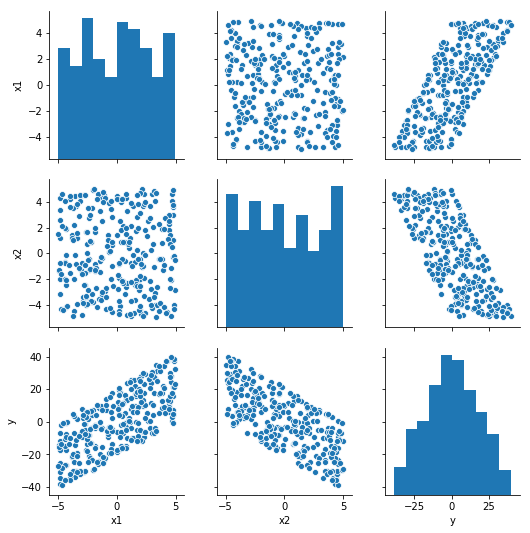

In [15]:
sns.pairplot(
    data=pd.DataFrame(np.hstack([x_ND, y_N[:,np.newaxis]]), columns=['x1', 'x2', 'y']));

### Example: Make predictions with 0-layer NN whose parameters  are filled with the 'true' params for our toy dataset

In [16]:
true_nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=2, n_dims_output=1)
true_nn_params[0]['w'][:] = true_w_D[:,np.newaxis]
true_nn_params[0]['b'][:] = true_bias

Text(0.5,0,u'predicted y|x')

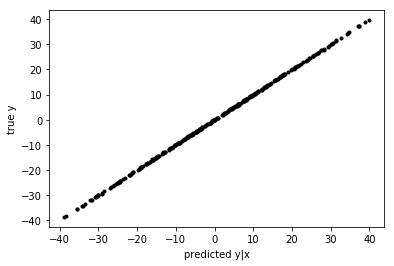

In [17]:
yhat_N = predict_y_given_x_with_NN(x_ND, true_nn_params)
assert yhat_N.size == N

plt.plot(yhat_N, y_N, 'k.')
plt.ylabel('true y')
plt.xlabel('predicted y|x')

### Example: Make predictions with 0-layer NN whose parameters  are filled with all zeros

Text(0.5,0,u'predicted y|x')

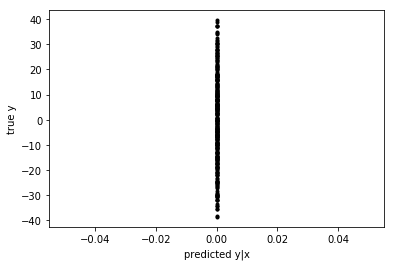

In [18]:
zero_nn_params = make_nn_params_as_list_of_dicts(n_hiddens_per_layer_list=[], n_dims_input=2, n_dims_output=1)
yhat_N = predict_y_given_x_with_NN(x_ND, zero_nn_params)
assert yhat_N.size == N

plt.plot(yhat_N, y_N, 'k.')
plt.ylabel('true y')
plt.xlabel('predicted y|x')

## Setup: Gradient descent implementation that can use list-of-dict parameters (not just arrays)

In [19]:
def run_many_iters_of_gradient_descent_with_list_of_dict(f, g, init_x_list_of_dict=None, n_iters=100, step_size=0.001):

    # Copy the initial parameter vector
    x_list_of_dict = copy.deepcopy(init_x_list_of_dict)

    # Create data structs to track the per-iteration history of different quantities
    history = dict(
        iter=[],
        f=[],
        x=[],
        g=[])
    start_time = time.time()
    for iter_id in range(n_iters):
        if iter_id > 0:
            # Gradient is a list of layer-specific dicts
            grad_list_of_dict = g(x_list_of_dict)
            for layer_id, x_layer_dict in enumerate(x_list_of_dict):
                for key in x_layer_dict.keys():
                    x_layer_dict[key] = x_layer_dict[key] - step_size * grad_list_of_dict[layer_id][key]
                    
        fval = f(x_list_of_dict)
        history['iter'].append(iter_id)
        history['f'].append(fval)
        history['x'].append(copy.deepcopy(x_list_of_dict))
        history['g'].append(g(x_list_of_dict))

        if iter_id < 3 or (iter_id+1) % 50 == 0:
            print("completed iter %5d/%d after %7.1f sec | loss %.6e" % (
                iter_id+1, n_iters, time.time()-start_time, fval))
    return x_list_of_dict, history

# Worked Exercise: Train 0-layer NN via gradient descent on LINEAR toy data

In [20]:
def nn_regression_loss_function(nn_params):
    yhat_N = predict_y_given_x_with_NN(x_ND, nn_params)
    return 0.5 / ag_np.square(sigma) * ag_np.sum(np.square(y_N - yhat_N))

In [21]:
fromtrue_opt_nn_params, fromtrue_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nn_regression_loss_function,
    autograd.grad(nn_regression_loss_function),
    true_nn_params,
    n_iters=100,
    step_size=0.000001)

completed iter     1/100 after     0.1 sec | loss 1.632803e+02
completed iter     2/100 after     0.3 sec | loss 1.626805e+02
completed iter     3/100 after     0.5 sec | loss 1.622965e+02
completed iter    50/100 after     8.8 sec | loss 1.598157e+02
completed iter   100/100 after    17.6 sec | loss 1.596883e+02


In [22]:
pretty_print_nn_param_list(fromtrue_opt_nn_params)

Layer 0
  w | size    (2, 1) | [ 4.20137427 -4.2023327 ]
  b | size      (1,) | [0.08737985]


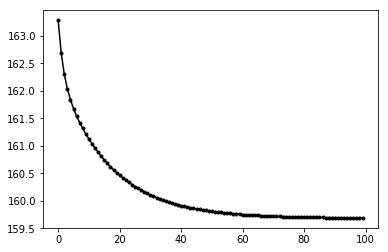

In [23]:
plt.plot(fromtrue_history['iter'], fromtrue_history['f'], 'k.-')

In [24]:
fromzero_opt_nn_params, fromzero_history = run_many_iters_of_gradient_descent_with_list_of_dict(
    nn_regression_loss_function,
    autograd.grad(nn_regression_loss_function),
    zero_nn_params,
    n_iters=100,
    step_size=0.000001)

completed iter     1/100 after     0.1 sec | loss 4.649827e+06
completed iter     2/100 after     0.3 sec | loss 2.520065e+06
completed iter     3/100 after     0.6 sec | loss 1.367394e+06
completed iter    50/100 after    10.7 sec | loss 1.634750e+02
completed iter   100/100 after    22.0 sec | loss 1.598624e+02


In [25]:
pretty_print_nn_param_list(fromzero_opt_nn_params)

Layer 0
  w | size    (2, 1) | [ 4.20137256 -4.2023501 ]
  b | size      (1,) | [0.08325989]


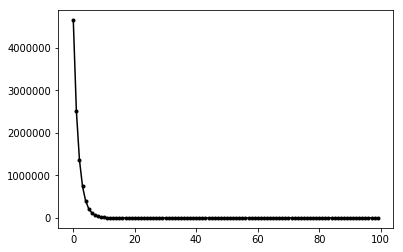

In [26]:
plt.plot(fromzero_history['iter'], fromzero_history['f'], 'k.-')

# Try it yourself!

* Can you make a function **calc_prior_logpdf** that takes in weights and produces a real value?
* Can you make a function **calc_likelihood_logpdf** that takes in weights and produces a real value?
* Can you make a function **calc_posterior_logpdf** that takes in weights and produces a real value?